In [1]:
######################################################################################################
## Etapa 0: Importando as bibliotecas necessárias
######################################################################################################
import os
import time

from concurrent.futures import ThreadPoolExecutor
from src.modules.image import Image, display_image
from src.modules.detection import Detection, display_image_with_detections
from src.modules.canny import Canny, display_canny
from src.modules.adjacency_matrix import AdjacencyMatrix
from src.modules.connected_components import ConnectedComponents, highlight_components
from src.modules.mst import MinimunSpanningTree
from src.modules.build_tree import BuildTree, plot_logest_path
from src.modules.sort_points import SortPoints, plot_sorted_points
from src.modules.compute_splines import ComputeSplines, plot_splines

subtrair de todos os pontos o ponto médio do rosto

dtw segmentado para cada característica

mexer na tensão e no passo da spline

quantidade de pixel na bounding box

fazer dtw 1D na imagem crua (Levada, A.)

perturbação nos pontos de uma mesma figura (Canny)

In [2]:
def process_image(file_path):
    try:
        start_step1 = time.time()
        print("Etapa 1: Leitura da imagem")
        img = Image(file_path)
        img.reading_image()
        end_step1 = time.time()


        # Etapa 2: Detecção de características
        print("Etapa 2: Detecção de características")
        detection = Detection(img.gray_image)
        detection.compute_all_detections()
        end_step2 = time.time()
        # print(detection.nose.x, detection.nose.y)


        # Etapa 3: Detecção de bordas
        print("Etapa 3: Detecção de bordas")
        canny = Canny(detection.mouth.img, detection.mouth.x, detection.mouth.y,
                      detection.nose.img, detection.nose.x, detection.nose.y,
                      detection.left_eye.img, detection.left_eye.x, detection.left_eye.y,
                      detection.right_eye.img, detection.right_eye.x, detection.right_eye.y)
        canny.compute_all_edges()
        end_step3 = time.time()


        # Etapa 4: Criação das matrizes de adjacência
        print("Etapa 4: Criação das matrizes de adjacência")
        adjacency_matrix = AdjacencyMatrix(canny.mouth_dict, canny.nose_dict, canny.left_eye_dict, canny.right_eye_dict)
        adjacency_matrix.compute_all_matrices()
        end_step4 = time.time()

        # Etapa 5: Cálculo de componentes conectados para cada matriz
        print("Etapa 5: Cálculo de componentes conectados para cada matriz")
        components_results = ConnectedComponents(adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        components_results.compute_all_components()
        components_results.compute_main_cc()
        end_step5 = time.time()
        # Etapa 6: Cálculo da árvore geradora mínima
        print("Etapa 6: Cálculo da árvore geradora mínima")
        mst = MinimunSpanningTree(components_results.dic_main_nose_cc, components_results.dic_main_mouth_cc, components_results.dic_main_left_eye_cc, components_results.dic_main_right_eye_cc,
                                  adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        mst.compute_all_mst()
        end_step6 = time.time()

        # Etapa 7: Construção da árvore e poda
        print("Etapa 7: Construção da árvore e poda")
        tree = BuildTree(mst.min_trees_nose, mst.min_trees_mouth, mst.min_trees_left_eye, mst.min_trees_right_eye)
        tree.compute_all_trees()
        end_step7 = time.time()

        # Etapa 7: Construção da árvore e poda
        print("Etapa 8: Ordenando os pontos")
        sort = SortPoints(tree.new_longest_path_nose, tree.new_longest_path_mouth, tree.new_longest_path_left_eye, tree.new_longest_path_right_eye,
                          mst.nodes_nose, mst.nodes_mouth, mst.nodes_left_eye, mst.nodes_right_eye,
                          canny.nose_dict, canny.mouth_dict, canny.left_eye_dict, canny.right_eye_dict)
        sort.compute_all_coordenates()


        # Etapa 8: Splines
        print("Etapa 8: Splines")
        splines = ComputeSplines(sort.sorted_coord_nose, sort.sorted_coord_mouth, sort.sorted_coord_left_eye, sort.sorted_coord_right_eye)
        splines.compute_all_splines()
        end_step8 = time.time()

        

        print(f"Processado: {file_path}")
        print(f"Tempo1 {end_step1 - start_step1}\nTempo2 {end_step2 - end_step1}\nTempo3 {end_step3 - end_step2}\nTempo4 {end_step4 - end_step3}\nTempo5 {end_step5 - end_step4}\nTempo6 {end_step6 - end_step5}\nTempo7 {end_step7 - end_step6}\nTempo8 {end_step8 - end_step7}")
        return img, detection, canny, adjacency_matrix, components_results, mst, tree, sort, splines

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

    
    
directory = './unzip_images'

file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('00029_940519_fa.ppm.ppm'))]

with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_image, file_paths))
    # quero guardar os 3 primeiros strings do file_path
    tag = [os.path.basename(file_path).split('.')[0].split('_')[0] for file_path in file_paths]

    results_tag = []
    for i in range(len(results)):
        if results[i] is not None:
            results_tag.append((f"{tag[i]}_{i}", results[i]))



Etapa 1: Leitura da imagem
Etapa 2: Detecção de características
Etapa 3: Detecção de bordas
Etapa 4: Criação das matrizes de adjacência
Etapa 5: Cálculo de componentes conectados para cada matriz
Etapa 6: Cálculo da árvore geradora mínima
Etapa 7: Construção da árvore e poda
Etapa 8: Ordenando os pontos
Etapa 8: Splines
Processado: ./unzip_images\00029_940519_fa.ppm.ppm
Tempo1 0.030438661575317383
Tempo2 0.5947461128234863
Tempo3 0.002935171127319336
Tempo4 0.01784062385559082
Tempo5 0.015825748443603516
Tempo6 0.008029699325561523
Tempo7 0.017133712768554688
Tempo8 0.008091449737548828


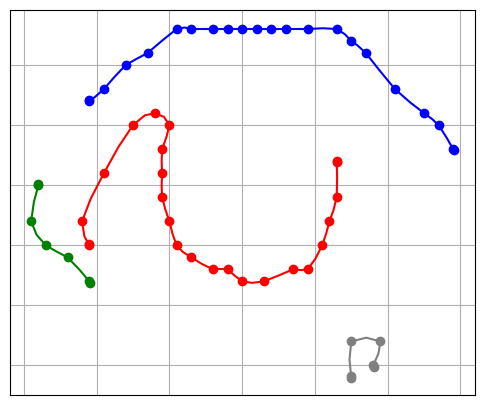

In [4]:
plot_splines(results[0][8].all_X_right_eye, results[0][8].all_Y_right_eye, results[0][8].all_control_x_right_eye, results[0][8].all_control_y_right_eye, name="right_eye")

In [3]:
results_tag

[('00029_0',
  (<src.modules.image.Image at 0x28d68eb8790>,
   <src.modules.compute_splines.ComputeSplines at 0x28d68eacb80>)),
 ('00029_1',
  (<src.modules.image.Image at 0x28d68eb8fa0>,
   <src.modules.compute_splines.ComputeSplines at 0x28d695e2e00>)),
 ('00029_2',
  (<src.modules.image.Image at 0x28d68eb8e80>,
   <src.modules.compute_splines.ComputeSplines at 0x28d6a9c9420>)),
 ('00029_3',
  (<src.modules.image.Image at 0x28d68eb9ab0>,
   <src.modules.compute_splines.ComputeSplines at 0x28d6a8fd4b0>)),
 ('00029_4',
  (<src.modules.image.Image at 0x28d68eb9930>,
   <src.modules.compute_splines.ComputeSplines at 0x28d4a96a530>)),
 ('00029_5',
  (<src.modules.image.Image at 0x28d68eb86d0>,
   <src.modules.compute_splines.ComputeSplines at 0x28d768e33d0>)),
 ('00029_6',
  (<src.modules.image.Image at 0x28d68eb99f0>,
   <src.modules.compute_splines.ComputeSplines at 0x28d7689a6e0>)),
 ('00029_7',
  (<src.modules.image.Image at 0x28d68eb8a00>,
   <src.modules.compute_splines.ComputeSplin

In [4]:
import numpy as np

def points(left_eye_x, right_eye_x, nose_x, mouth_x,
           left_eye_y, right_eye_y, nose_y, mouth_y):
    # Adiciona os pontos da boca
    le1 = np.concatenate([arr.flatten() for arr in left_eye_x]).tolist()
    re1 = np.concatenate([arr.flatten() for arr in right_eye_x]).tolist()
    m1 = np.concatenate([arr.flatten() for arr in mouth_x]).tolist()
    n1 = np.concatenate([arr.flatten() for arr in nose_x]).tolist()

    x1 = np.concatenate([le1, re1, m1, n1]).tolist()

    le1 = np.concatenate([arr.flatten() for arr in left_eye_y]).tolist()
    re1 = np.concatenate([arr.flatten() for arr in right_eye_y]).tolist()
    m1 = np.concatenate([arr.flatten() for arr in mouth_y]).tolist()
    n1 = np.concatenate([arr.flatten() for arr in nose_y]).tolist()

    y1 = np.concatenate([le1, re1, m1, n1]).tolist()
    points1 = list(zip(x1, y1))

    return points1

In [5]:
len(results_tag)

24

In [6]:
import pandas as pd
df_people_points = pd.DataFrame(columns=['tag', 'points'])

for i in range(len(results_tag)):
    teste = points(results_tag[i][1][8].all_X_left_eye, 
                results_tag[i][1][8].all_X_right_eye,
                results_tag[i][1][8].all_X_nose,
                results_tag[i][1][8].all_X_mouth,
                results_tag[i][1][8].all_Y_left_eye,
                results_tag[i][1][8].all_Y_right_eye,
                results_tag[i][1][8].all_Y_nose,
                results_tag[i][1][8].all_Y_mouth)
    tag = results_tag[i][0]
    df_people_points = pd.concat([df_people_points, pd.DataFrame({'tag': [tag], 'points': [teste]})], ignore_index=True)


In [7]:
df_people_points.head()

,tag,points
0,00029_0,"[(80.0, 98.0), (77.0, 100.0), (75.0, 101.0), (..."
1,00029_1,"[(41.0, 89.0), (44.0, 87.0), (47.0, 85.0), (49..."
2,00029_2,"[(66.0, 130.0), (70.0, 128.0), (72.0, 127.0), ..."
3,00029_3,"[(85.0, 158.0), (87.0, 156.0), (89.0, 155.0), ..."
4,00029_4,"[(99.0, 137.0), (101.0, 137.0), (103.0, 136.0)..."


In [8]:
def dtw_2d_curve(series1, series2):
    n, m = len(series1), len(series2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(np.array(series1[i-1]) - np.array(series2[j-1]))
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],    # inserção
                dtw_matrix[i, j - 1],    # remoção
                dtw_matrix[i - 1, j - 1] # match
            )

    return dtw_matrix[n, m]


In [9]:
import pandas as pd
import numpy as np

# Cria a matriz de distâncias vazia
unique_ids = df_people_points["tag"].tolist()
df_distances = pd.DataFrame(index=unique_ids, columns=unique_ids, dtype=float)

# Preenche apenas a parte superior da matriz
for i in range(len(df_people_points)):
    for j in range(i + 1, len(df_people_points)):
        uid_i = df_people_points["tag"].iloc[i]
        uid_j = df_people_points["tag"].iloc[j]

        # print(f"Comparando {uid_i} e {uid_j}")
        distance = dtw_2d_curve(df_people_points["points"].iloc[i],
                                df_people_points["points"].iloc[j])
        # print(f"DTW distance (2D curves): {distance:.4f}")

        df_distances.loc[uid_i, uid_j] = distance


In [ ]:
# Espelha a parte superior para preencher a inferior
df_distances = df_distances.combine_first(df_distances.T)

# Remove a diagonal (opcional: substitui por NaN)
np.fill_diagonal(df_distances.values, np.nan)

# Encontra o menor valor de cada linha (ignorando a diagonal)
min_values = df_distances.min(axis=1)
min_columns = df_distances.idxmin(axis=1)

# Junta em DataFrame final
df_min = pd.DataFrame({
    "unique_id": df_distances.index,
    "closest_id": min_columns,
    "min_distance": min_values
}).reset_index(drop=True)

In [69]:
df_distances

,00029_0,00029_1,00029_2,00029_3,00029_4,00029_5,00029_6,00029_7,00029_8,00029_9,00070_10,00070_11,00070_12,00146_13,00146_14,00146_15,00146_16,00146_17,00146_18,00732_19,00732_20,00732_21,00732_22,00732_23
00029_0,NaN,14314.963060,19200.682932,62639.805735,45877.599785,23696.107394,9192.284984,10352.818641,14639.668947,66076.904060,46365.173546,7914.997883,16246.750301,42590.768190,48264.954465,27201.674505,22738.186417,23478.052188,58334.096106,51581.356627,51422.019855,14800.715104,19445.285745,47290.569392
00029_1,14314.963060,NaN,25480.352580,72924.593251,53338.061685,25591.145425,10564.708509,8677.531587,17170.540547,79460.823771,63187.089620,11215.422860,21277.482367,46222.107474,49482.947296,26542.183952,24438.965678,26982.671622,70490.566830,53907.888360,55531.670131,12452.971699,24197.168047,54631.104994
00029_2,19200.682932,25480.352580,NaN,38039.386544,23303.825699,6406.856828,11554.224576,9654.530355,5244.891260,41091.342568,19938.494576,9333.678815,5149.204109,20608.988101,23257.410431,9672.786046,8601.584705,8382.947825,33820.356368,29532.272247,29772.761270,6162.734472,4024.330219,24681.586110
00029_3,62639.805735,72924.593251,38039.386544,NaN,16829.634406,30653.681196,46422.211713,44096.940846,42532.711669,10499.958474,30161.366270,46269.681827,39012.106464,19855.955972,17241.270512,25638.872621,29835.576836,34803.358798,26352.065420,11635.275257,15347.560159,43157.947694,37616.457625,17700.758570
00029_4,45877.599785,53338.061685,23303.825699,16829.634406,NaN,18803.022813,30738.193910,28651.390498,27860.617092,15981.008651,20394.376314,30840.463780,25138.564020,7359.572588,14325.613538,14409.850001,20432.715818,20722.979171,22080.029883,12723.059016,10647.361220,27481.609476,23298.783739,15240.648038
00029_5,23696.107394,25591.145425,6406.856828,30653.681196,18803.022813,NaN,12653.621949,11155.400600,8886.410158,35887.344512,13250.075623,10020.843072,6816.547589,17164.919430,16255.553254,6092.694792,9672.312112,7419.832045,26472.626771,24517.527614,24799.095724,8149.396272,6986.191899,19265.113722
00029_6,9192.284984,10564.708509,11554.224576,46422.211713,30738.193910,12653.621949,NaN,2012.016145,7201.596131,49784.163109,35141.534483,3656.106682,10907.397396,27914.606354,30590.762890,14377.259370,10416.879724,15179.321583,41071.333185,35361.442903,35691.660592,6805.395123,11459.162763,31566.790190
00029_7,10352.818641,8677.531587,9654.530355,44096.940846,28651.390498,11155.400600,2012.016145,NaN,4956.303642,48266.418497,31626.965151,3213.474968,8910.526026,26297.294350,28335.571687,12648.567674,9849.700916,13117.467848,40068.375276,33504.092880,34173.485216,4715.240629,10359.043875,29595.213916
00029_8,14639.668947,17170.540547,5244.891260,42532.711669,27860.617092,8886.410158,7201.596131,4956.303642,NaN,48804.757376,24067.820982,6282.006721,5819.965725,24288.158139,25841.034042,11616.716976,11112.063828,8900.919251,38912.448369,32733.848673,34055.938010,3644.748448,6263.413105,29071.776792
00029_9,66076.904060,79460.823771,41091.342568,10499.958474,15981.008651,35887.344512,49784.163109,48266.418497,48804.757376,NaN,34203.587665,51172.038449,45350.650704,19167.877217,19448.003894,31034.845132,32900.853635,39710.160621,23305.714869,11429.848069,13939.644737,49429.325523,42057.152120,18057.799500


In [68]:
df_min

,unique_id,closest_id,min_distance
0,00029_0,00070_11,7914.997883
1,00029_1,00029_7,8677.531587
2,00029_2,00732_22,4024.330219
3,00029_3,00029_9,10499.958474
4,00029_4,00146_13,7359.572588
5,00029_5,00146_15,6092.694792
6,00029_6,00029_7,2012.016145
7,00029_7,00029_6,2012.016145
8,00029_8,00732_21,3644.748448
9,00029_9,00029_3,10499.958474


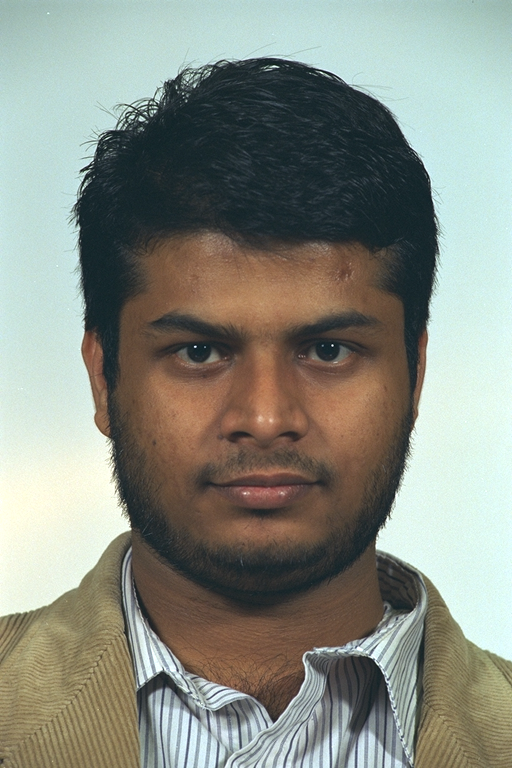

In [71]:
results_tag[12][1][0].open 

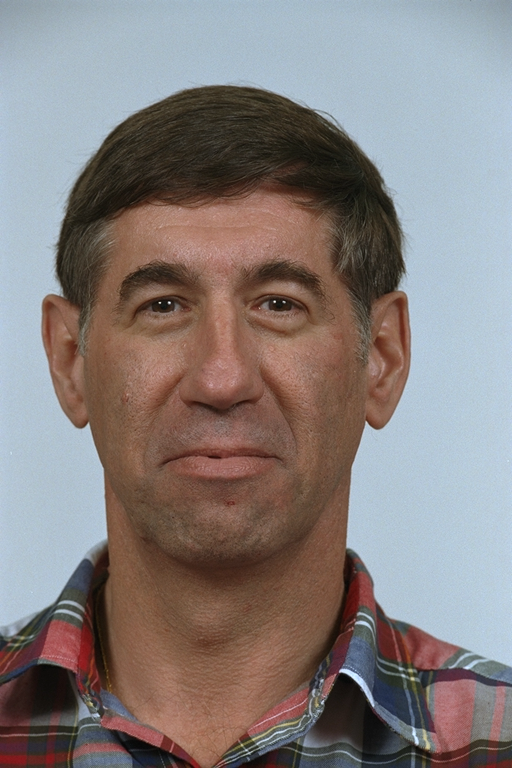

In [63]:
results_tag[15][1][0].open

In [13]:
import pandas as pd
import numpy as np

# Suponha que você tenha uma lista de 'tags'
tags = df_people_points["tag"].tolist()

# Criar um DataFrame para armazenar as distâncias (triangular superior)
df_distances = pd.DataFrame(index=tags, columns=tags, dtype=float)

for i in range(len(df_people_points)):
    for j in range(i + 1, len(df_people_points)):
        tag_i = df_people_points["tag"].iloc[i]
        tag_j = df_people_points["tag"].iloc[j]
        
        print(f"Comparando {tag_i} e {tag_j}")
        
        distance = dtw_2d_curve(df_people_points["points"].iloc[i],
                                df_people_points["points"].iloc[j])
        
        print(f"DTW distance (2D curves): {distance:.4f}")
        
        # Preenche apenas a parte superior
        df_distances.loc[tag_i, tag_j] = distance


Comparando 00029 e 00029
DTW distance (2D curves): 14505.5209
Comparando 00029 e 00029
DTW distance (2D curves): 21111.6616
Comparando 00029 e 00029
DTW distance (2D curves): 62451.8918
Comparando 00029 e 00029
DTW distance (2D curves): 40472.2363
Comparando 00029 e 00029
DTW distance (2D curves): 23792.9585
Comparando 00029 e 00029


KeyboardInterrupt: 

In [ ]:

# Calcular a distância DTW entre as curvas
for i in range(len(df_people_points)):
    for j in range(i+1, len(df_people_points)):
        print(f"Comparando {df_people_points['tag'].iloc[i]} e {df_people_points['tag'].iloc[j]}")
        distance = dtw_2d_curve(df_people_points["points"].iloc[i], df_people_points["points"].iloc[j])
        print(f"DTW distance (2D curves): {distance:.4f}")

        df_people_points.loc[i, f"distance_{df_people_points['tag'].iloc[j]}_{j}"] = distance


0
Comparando 00029 e 00029
DTW distance (2D curves): 14505.5209
Comparando 00029 e 00029
DTW distance (2D curves): 21111.6616
Comparando 00029 e 00029
DTW distance (2D curves): 62451.8918
Comparando 00029 e 00029


KeyboardInterrupt: 

In [46]:
distance = dtw_2d_curve(df_people_points["points"].iloc[0] , df_people_points["points"].iloc[23] )
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 47269.5264


In [4]:
# display_image(results[0][0].open)


# display_image_with_detections(results[0][0].image, results[0][1].face, results[0][1].nose, results[0][1].mouth, results[0][1].left_eye, results[0][1].right_eye)


# display_canny(results[0][2].nose_edge, name='03_nose_edge')
# display_canny(results[0][2].mouth_edge, name='03_mouth_edge')
# display_canny(results[0][2].left_eye_edge, name='03_left_eye_edge')
# display_canny(results[0][2].right_eye_edge, name='03_right_eye_edge')

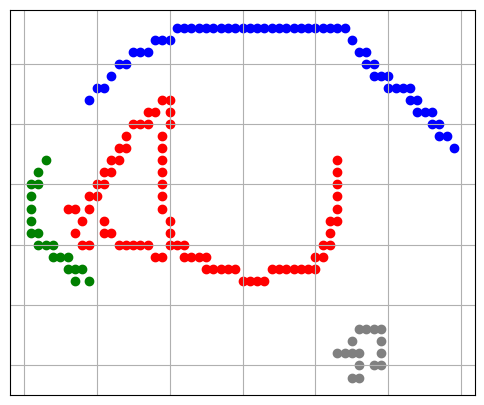

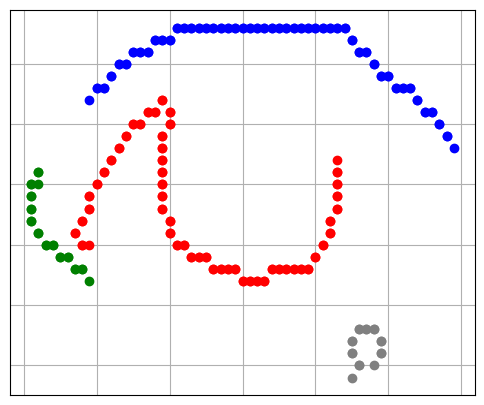

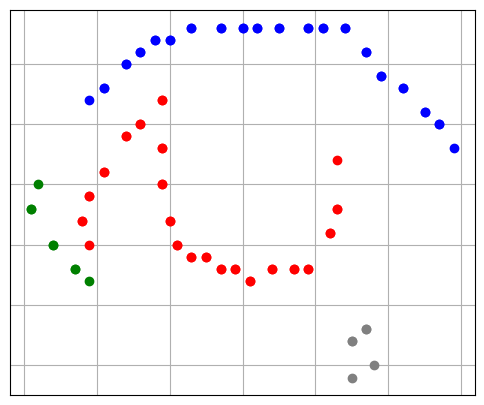

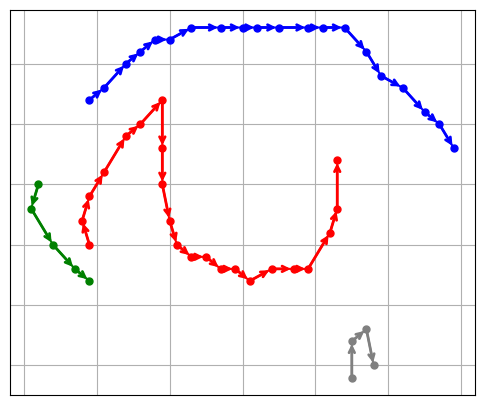

In [5]:
highlight_components(results[0][2].right_eye_dict, results[0][4].dic_main_right_eye_cc, "right_eye")
plot_logest_path(results[0][2].right_eye_dict, results[0][6].longest_path_right_eye, results[0][5].nodes_right_eye, name='05_longest_path_right_eye')
plot_logest_path(results[0][2].right_eye_dict, results[0][6].new_longest_path_right_eye, results[0][5].nodes_right_eye, name='06_new_longest_path_right_eye')
plot_sorted_points(results[0][7].sorted_coord_right_eye, "right_eye")
# plot_splines(results[0][8].all_X_right_eye, results[0][8].all_Y_right_eye, results[0][8].all_control_x_right_eye, results[0][8].all_control_y_right_eye, name="right_eye")


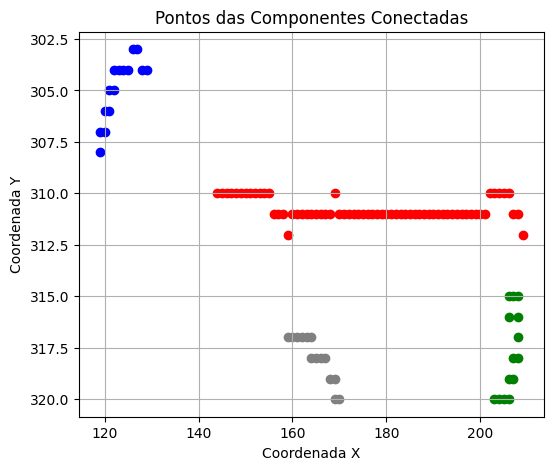

In [12]:
highlight_components(results[0][2].mouth_dict, results[0][4].dic_main_mouth_cc, "mouth")
# plot_logest_path(results[0][2].mouth_dict, results[0][6].longest_path_mouth, results[0][5].nodes_mouth, name='05_longest_path_mouth')
# plot_logest_path(results[0][2].mouth_dict, results[0][6].new_longest_path_mouth, results[0][5].nodes_mouth, name='06_new_longest_path_mouth')
# plot_sorted_points(results[0][7].sorted_coord_mouth, "mouth")
# plot_splines(results[0][8].all_X_mouth, results[0][8].all_Y_mouth, results[0][8].all_control_x_mouth, results[0][8].all_control_y_mouth, name="mouth")


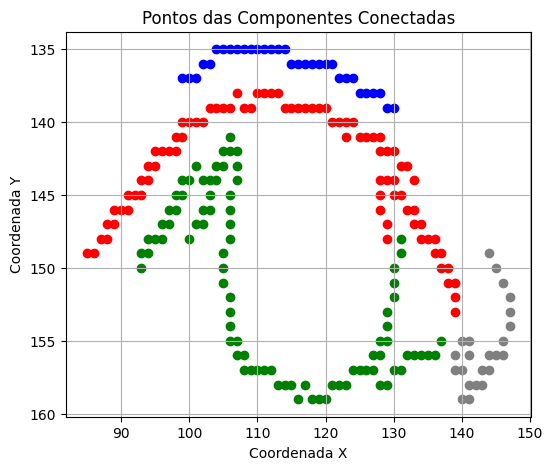

In [5]:
highlight_components(results[0][2].left_eye_dict, results[0][4].dic_main_left_eye_cc, "left_eye")
# plot_logest_path(results[0][2].left_eye_dict, results[0][6].longest_path_left_eye, results[0][5].nodes_left_eye, name='05_longest_path_left_eye')
# plot_logest_path(results[0][2].left_eye_dict, results[0][6].new_longest_path_left_eye, results[0][5].nodes_left_eye, name='06_new_longest_path_left_eye')
# plot_sorted_points(results[0][7].sorted_coord_left_eye, "left_eye")
# plot_splines(results[0][8].all_X_left_eye, results[0][8].all_Y_left_eye, results[0][8].all_control_x_left_eye, results[0][8].all_control_y_left_eye, name="left_eye")


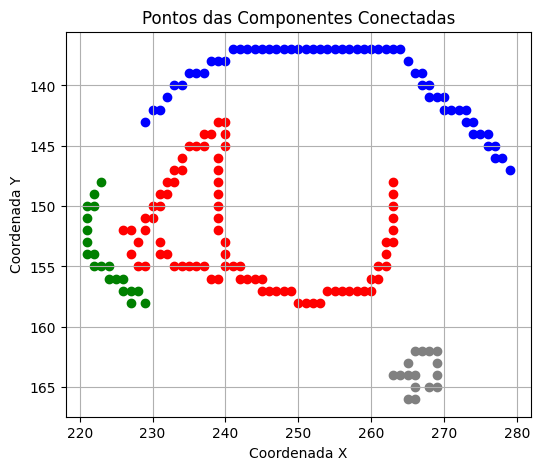

In [6]:
highlight_components(results[0][2].right_eye_dict, results[0][4].dic_main_right_eye_cc, "right_eye")
# plot_logest_path(results[0][2].right_eye_dict, results[0][6].longest_path_right_eye, results[0][5].nodes_right_eye, name='05_longest_path_right_eye')
# plot_logest_path(results[0][2].right_eye_dict, results[0][6].new_longest_path_right_eye, results[0][5].nodes_right_eye, name='06_new_longest_path_right_eye')
# plot_sorted_points(results[0][7].sorted_coord_right_eye, "right_eye")
# plot_splines(results[0][8].all_X_right_eye, results[0][8].all_Y_right_eye, results[0][8].all_control_x_right_eye, results[0][8].all_control_y_right_eye, name="right_eye")


In [4]:
import numpy as np
le1 = np.concatenate([arr.flatten() for arr in results[0][7].all_X_left_eye]).tolist()
re1 = np.concatenate([arr.flatten() for arr in results[0][7].all_X_right_eye]).tolist()
m1 = np.concatenate([arr.flatten() for arr in results[0][7].all_X_mouth]).tolist()
n1 = np.concatenate([arr.flatten() for arr in results[0][7].all_X_nose]).tolist()

x1 = np.concatenate([le1, re1, m1, n1]).tolist()

le1 = np.concatenate([arr.flatten() for arr in results[0][7].all_Y_left_eye]).tolist()
re1 = np.concatenate([arr.flatten() for arr in results[0][7].all_Y_right_eye]).tolist()
m1 = np.concatenate([arr.flatten() for arr in results[0][7].all_Y_mouth]).tolist()
n1 = np.concatenate([arr.flatten() for arr in results[0][7].all_Y_nose]).tolist()

y1 = np.concatenate([le1, re1, m1, n1]).tolist()
points1 = list(zip(x1, y1))

In [ ]:
points1

In [8]:
le2 = np.concatenate([arr.flatten() for arr in results[1][7].all_X_left_eye]).tolist()
re2 = np.concatenate([arr.flatten() for arr in results[1][7].all_X_right_eye]).tolist()
m2 = np.concatenate([arr.flatten() for arr in results[1][7].all_X_mouth]).tolist()
n2 = np.concatenate([arr.flatten() for arr in results[1][7].all_X_nose]).tolist()

x2 = np.concatenate([le2, re2, m2, n2]).tolist()

le2 = np.concatenate([arr.flatten() for arr in results[1][7].all_Y_left_eye]).tolist()
re2 = np.concatenate([arr.flatten() for arr in results[1][7].all_Y_right_eye]).tolist()
m2 = np.concatenate([arr.flatten() for arr in results[1][7].all_Y_mouth]).tolist()
n2 = np.concatenate([arr.flatten() for arr in results[1][7].all_Y_nose]).tolist()

y2 = np.concatenate([le2, re2, m2, n2]).tolist()
points2 = list(zip(x2, y2))

In [9]:
import numpy as np
le3 = np.concatenate([arr.flatten() for arr in results[2][7].all_X_left_eye]).tolist()
re3 = np.concatenate([arr.flatten() for arr in results[2][7].all_X_right_eye]).tolist()
m3 = np.concatenate([arr.flatten() for arr in results[2][7].all_X_mouth]).tolist()
n3 = np.concatenate([arr.flatten() for arr in results[2][7].all_X_nose]).tolist()

x3 = np.concatenate([le3, re3, m3, n3]).tolist()

le3 = np.concatenate([arr.flatten() for arr in results[2][7].all_Y_left_eye]).tolist()
re3 = np.concatenate([arr.flatten() for arr in results[2][7].all_Y_right_eye]).tolist()
m3 = np.concatenate([arr.flatten() for arr in results[2][7].all_Y_mouth]).tolist()
n3 = np.concatenate([arr.flatten() for arr in results[2][7].all_Y_nose]).tolist()

y3 = np.concatenate([le3, re3, m3, n3]).tolist()

points3 = list(zip(x3, y3))

In [10]:
import numpy as np
le4 = np.concatenate([arr.flatten() for arr in results[3][7].all_X_left_eye]).tolist()
re4 = np.concatenate([arr.flatten() for arr in results[3][7].all_X_right_eye]).tolist()
m4 = np.concatenate([arr.flatten() for arr in results[3][7].all_X_mouth]).tolist()
n4 = np.concatenate([arr.flatten() for arr in results[3][7].all_X_nose]).tolist()

x4 = np.concatenate([le4, re4, m4, n4]).tolist()

le4 = np.concatenate([arr.flatten() for arr in results[3][7].all_Y_left_eye]).tolist()
re4 = np.concatenate([arr.flatten() for arr in results[3][7].all_Y_right_eye]).tolist()
m4 = np.concatenate([arr.flatten() for arr in results[3][7].all_Y_mouth]).tolist()
n4 = np.concatenate([arr.flatten() for arr in results[3][7].all_Y_nose]).tolist()

y4 = np.concatenate([le4, re4, m4, n4]).tolist()

points4 = list(zip(x4, y4))

In [11]:
len(points1), len(points2), len(points3), len(points4)

(395, 337, 280, 275)

In [12]:
points1

[(9.0, 1.0),
 (11.0, 1.0),
 (13.0, 1.0),
 (16.0, 1.0),
 (19.0, 2.0),
 (21.0, 2.0),
 (24.0, 2.0),
 (27.0, 4.0),
 (29.0, 5.0),
 (31.0, 5.0),
 (33.0, 6.0),
 (35.0, 7.0),
 (37.0, 8.0),
 (42.0, 7.0),
 (44.0, 8.0),
 (46.0, 8.0),
 (50.0, 9.0),
 (53.0, 10.0),
 (56.0, 11.0),
 (59.0, 11.0),
 (61.0, 11.0),
 (64.0, 12.0),
 (67.0, 13.0),
 (25.0, 25.0),
 (28.0, 26.0),
 (30.0, 24.0),
 (33.0, 25.0),
 (37.0, 25.0),
 (39.0, 24.0),
 (42.0, 24.0),
 (45.0, 24.0),
 (49.0, 23.0),
 (51.0, 23.0),
 (53.0, 25.0),
 (55.0, 24.0),
 (57.0, 25.0),
 (58.0, 27.0),
 (60.0, 28.0),
 (64.0, 27.0),
 (65.0, 25.0),
 (63.0, 23.0),
 (62.0, 20.0),
 (76.0, 34.0),
 (74.0, 34.0),
 (72.0, 33.0),
 (69.0, 30.0),
 (7.0, 36.0),
 (9.0, 34.0),
 (9.0, 32.0),
 (9.0, 31.0),
 (11.0, 33.0),
 (12.0, 31.0),
 (16.0, 30.0),
 (19.0, 29.0),
 (44.0, 41.0),
 (47.0, 41.0),
 (49.0, 39.0),
 (48.0, 37.0),
 (47.0, 34.0),
 (47.0, 32.0),
 (51.0, 32.0),
 (54.0, 33.0),
 (37.0, 53.0),
 (38.0, 51.0),
 (40.0, 50.0),
 (42.0, 50.0),
 (45.0, 50.0),
 (48.0, 48.0),
 (

In [13]:
import numpy as np

def dtw_2d_curve(series1, series2):
    n, m = len(series1), len(series2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(np.array(series1[i-1]) - np.array(series2[j-1]))
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],    # inserção
                dtw_matrix[i, j - 1],    # remoção
                dtw_matrix[i - 1, j - 1] # match
            )

    return dtw_matrix[n, m]

# Calcular a distância DTW entre as curvas
distance = dtw_2d_curve(points1, points2)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 7935.3257


In [14]:
distance = dtw_2d_curve(points1, points3)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 9296.9251


In [15]:
distance = dtw_2d_curve(points1, points4)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 7989.1989


In [16]:
distance = dtw_2d_curve(points2, points3)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 6807.5549


In [17]:
distance = dtw_2d_curve(points2, points4)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 7389.3882


In [18]:
distance = dtw_2d_curve(points3, points4)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 4605.2670


In [4]:
keys = results[2][4].dic_main_left_eye_cc[0]
keys


dicionario_filtrado = {k: v for k, v in results[2][2].left_eye_dict.items() if k in keys}
dicionario_filtrado

{0: (33, 0),
 1: (34, 0),
 2: (35, 0),
 3: (36, 0),
 4: (38, 0),
 12: (32, 1),
 13: (33, 1),
 14: (37, 1),
 15: (38, 1),
 28: (31, 2),
 29: (36, 2),
 30: (37, 2),
 37: (30, 3),
 38: (33, 3),
 39: (34, 3),
 40: (35, 3),
 44: (32, 4),
 47: (31, 5)}

In [5]:
keys

[0, 1, 2, 3, 4, 12, 13, 14, 15, 28, 29, 30, 37, 38, 39, 40, 44, 47]

In [8]:
results[2][5].nodes_left_eye

[[0, 1, 2, 3, 4, 12, 13, 14, 15, 28, 29, 30, 37, 38, 39, 40, 44, 47],
 [7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 32, 33],
 [65,
  66,
  67,
  74,
  75,
  76,
  77,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  97,
  98,
  99,
  100,
  101,
  102,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  123,
  124,
  125,
  126,
  127,
  128,
  135,
  136,
  137,
  138,
  139,
  140,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  160,
  161,
  167,
  170,
  178],
 [108, 109, 121, 122, 133, 134, 143, 144, 145, 158, 159, 166, 169, 176, 182],
 [190,
  191,
  192,
  193,
  194,
  195,
  205,
  206,
  207,
  208,
  209,
  212,
  213,
  214,
  215,
  216,
  217],
 [218,
  219,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  241,
  242,
  247,
  248,
  249,
  265,
  266,
  267,
  273,
  278,
  279,
  289,
  290,
  299,
  300,
  311,
  327,
  328],
 [245,
  246,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
 

In [7]:
results[2][6].longest_path_left_eye

[[17, 16, 13, 14, 15, 10, 7, 3, 2, 1, 0, 5, 9, 12],
 [14, 12, 3, 11, 10, 9, 2, 1, 0, 7, 6, 5],
 [2,
  6,
  5,
  4,
  12,
  11,
  10,
  9,
  18,
  17,
  16,
  22,
  29,
  38,
  45,
  44,
  37,
  36,
  35,
  43,
  42,
  41,
  40,
  34,
  27,
  20,
  14,
  21,
  15,
  8,
  3,
  0,
  1],
 [14, 13, 12, 11, 9, 6, 7, 4, 2, 0, 1],
 [10, 9, 8, 5, 4, 3, 2, 1, 0, 7, 6, 14, 13, 12, 11, 16],
 [33,
  32,
  31,
  28,
  27,
  25,
  23,
  21,
  20,
  18,
  17,
  16,
  15,
  14,
  13,
  12,
  11,
  10,
  1,
  9,
  8,
  7,
  6,
  5,
  4,
  3,
  0,
  2],
 [38,
  37,
  36,
  34,
  33,
  31,
  29,
  27,
  28,
  26,
  24,
  25,
  22,
  18,
  19,
  20,
  13,
  14,
  15,
  2,
  3,
  4,
  0,
  5,
  1,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  17],
 [60,
  53,
  45,
  40,
  36,
  37,
  32,
  27,
  19,
  12,
  6,
  13,
  22,
  29,
  33,
  38,
  43,
  48,
  55,
  56,
  61,
  62,
  63,
  57,
  49,
  50,
  58,
  59,
  51,
  44,
  39,
  34,
  30,
  23,
  15,
  8,
  3,
  0,
  1,
  2,
  5,
  10,
  11,
  17,
  18,
  25,
 

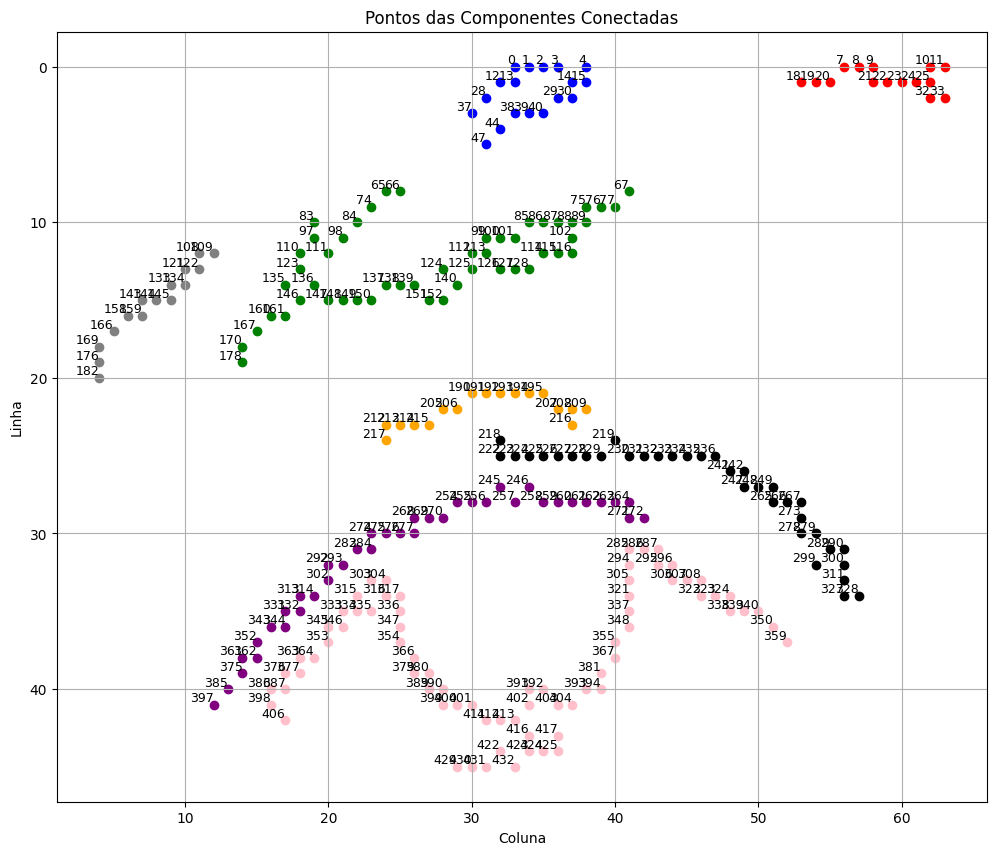

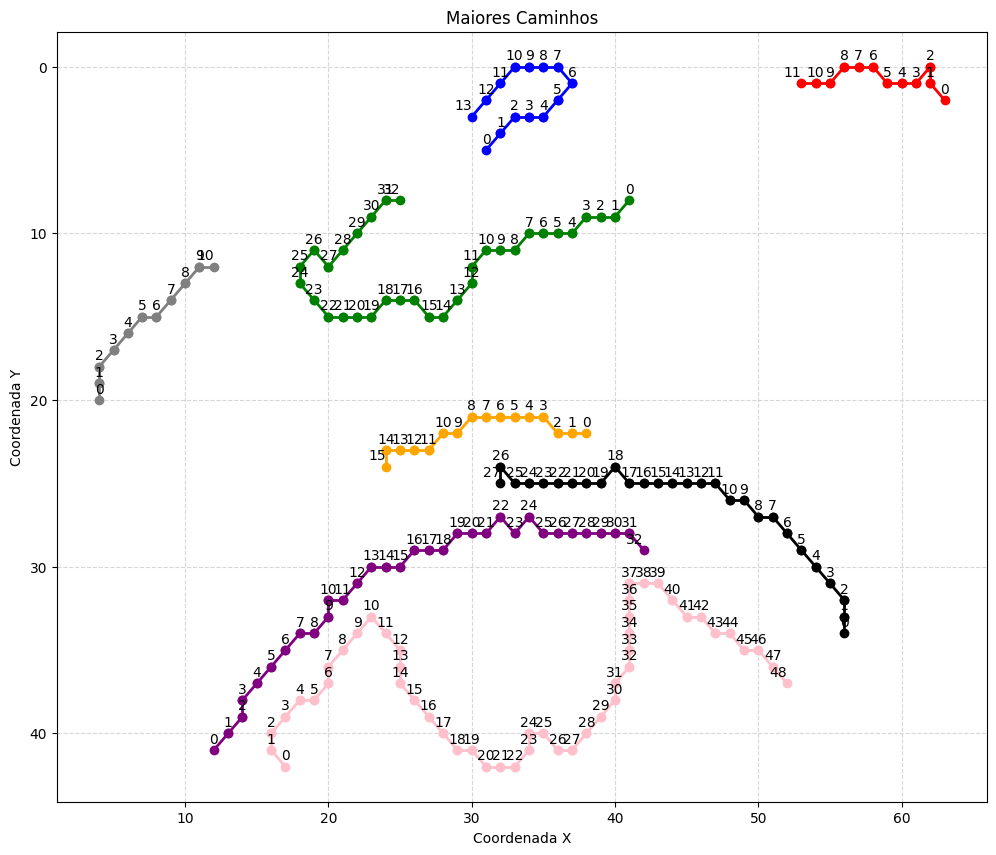

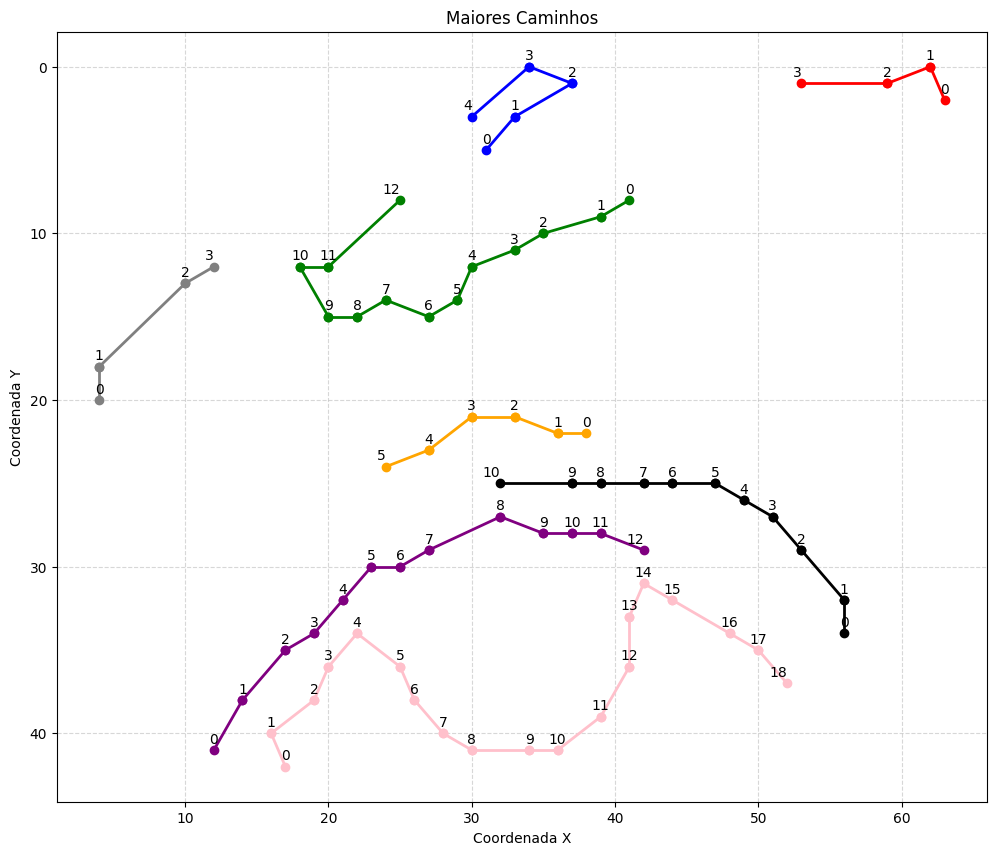

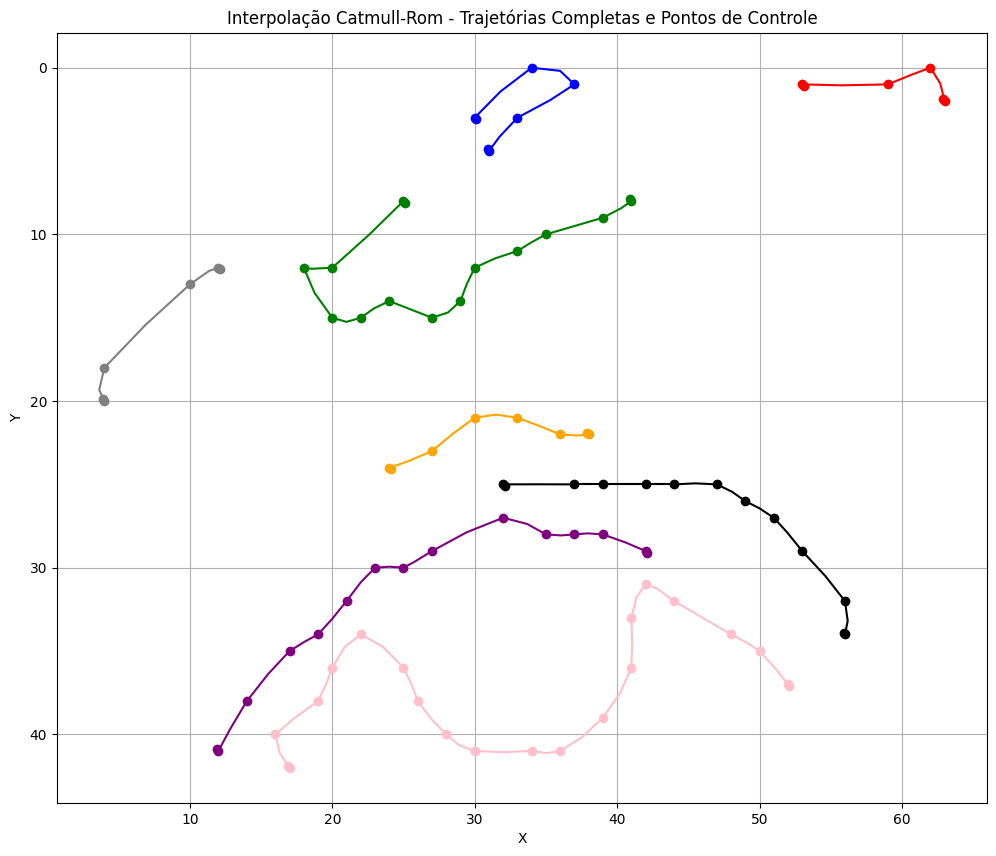

In [3]:
highlight_components(results[2][2].left_eye_dict, results[2][4].dic_main_left_eye_cc)
plot_logest_path(results[2][2].left_eye_dict, results[2][6].longest_path_left_eye, results[2][5].nodes_left_eye)
plot_logest_path(results[2][2].left_eye_dict, results[2][6].new_longest_path_left_eye, results[2][5].nodes_left_eye)
plot_splines(results[2][7].all_X_left_eye, results[2][7].all_Y_left_eye, results[2][7].all_control_x_left_eye, results[2][7].all_control_y_left_eye)


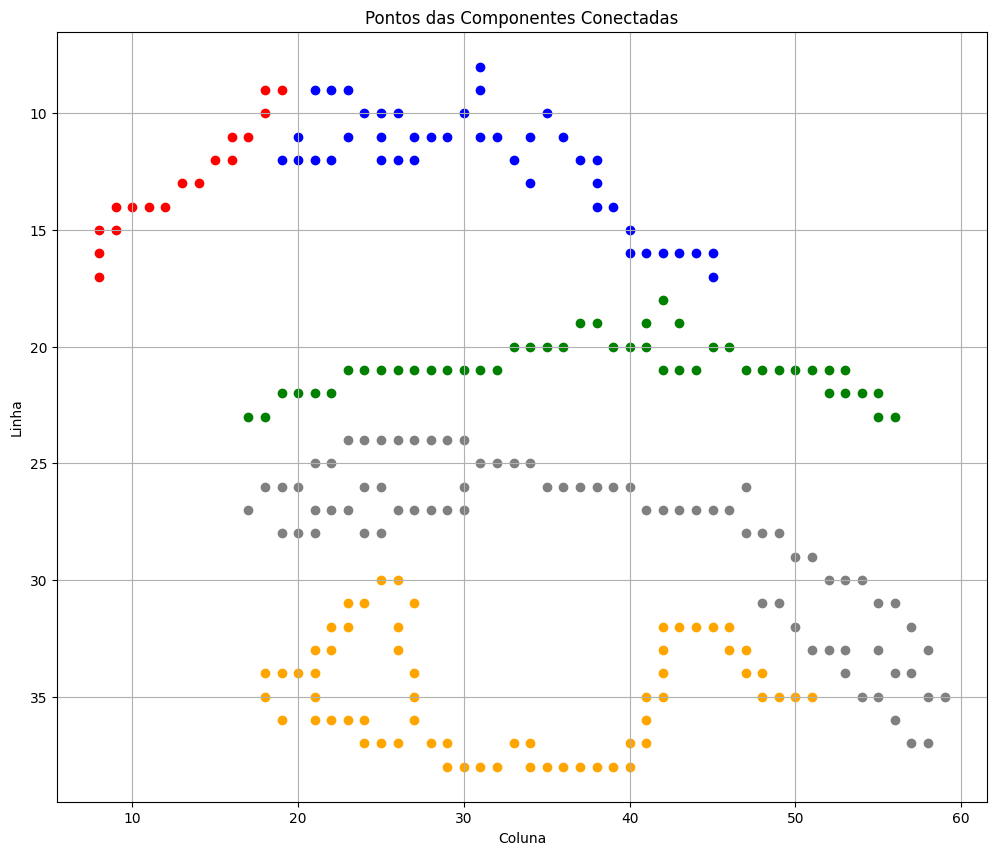

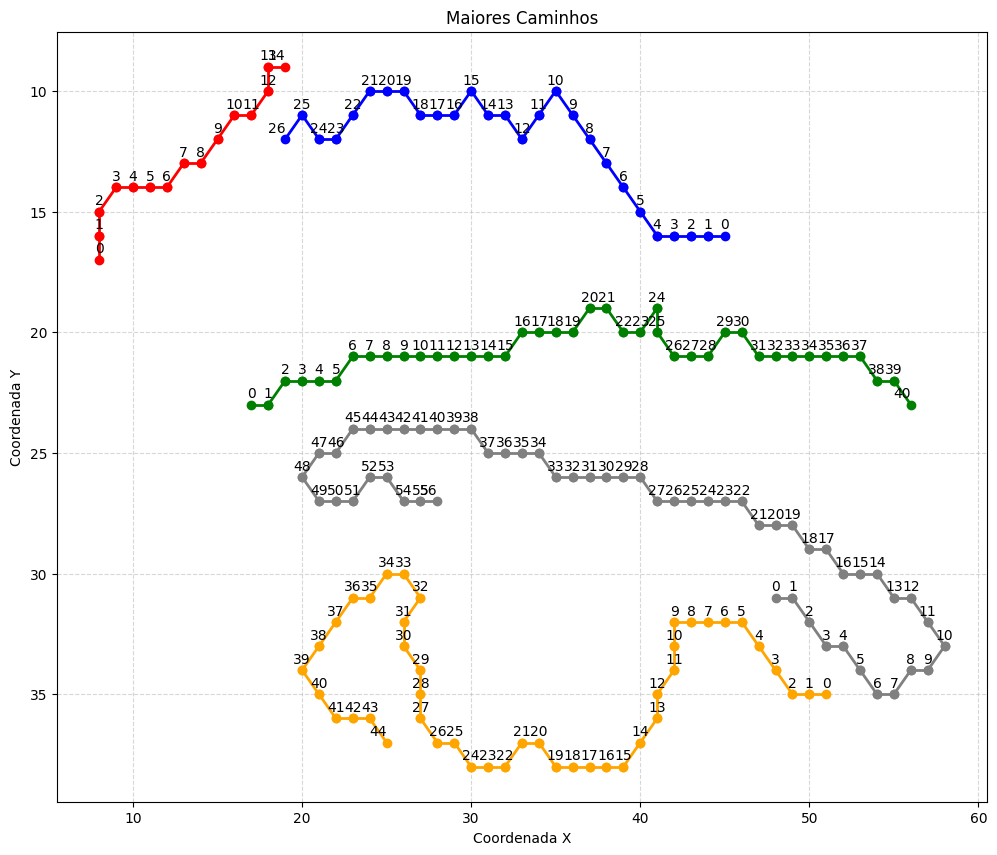

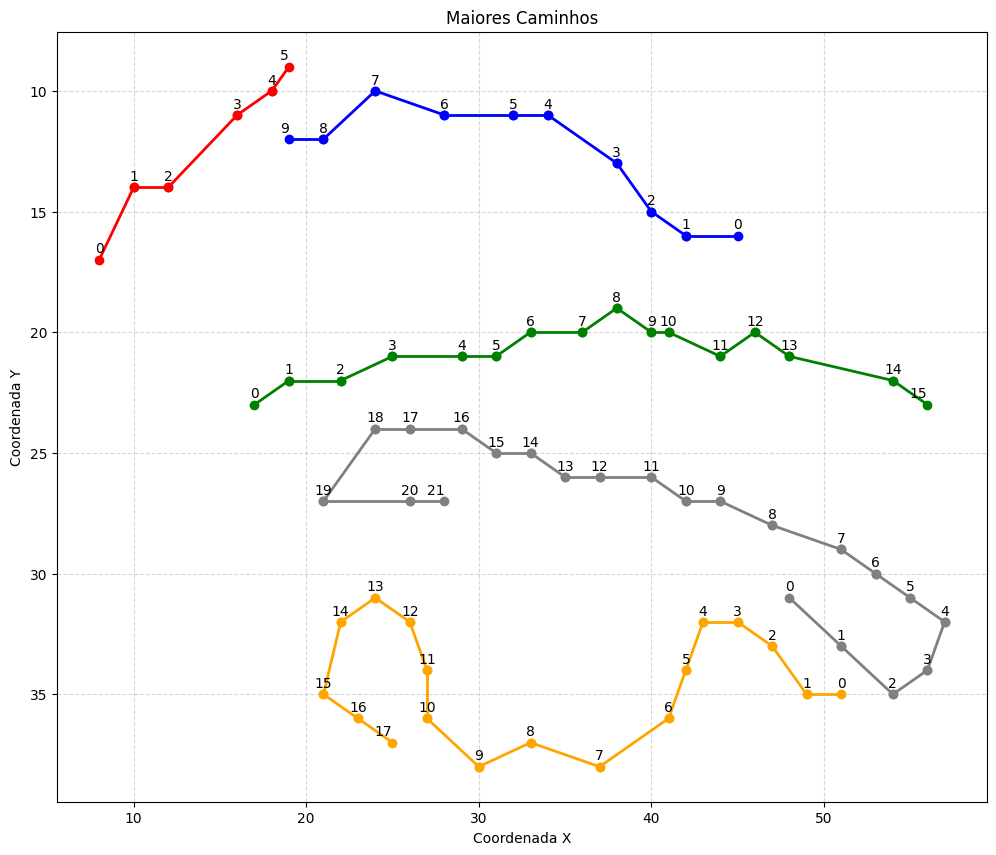

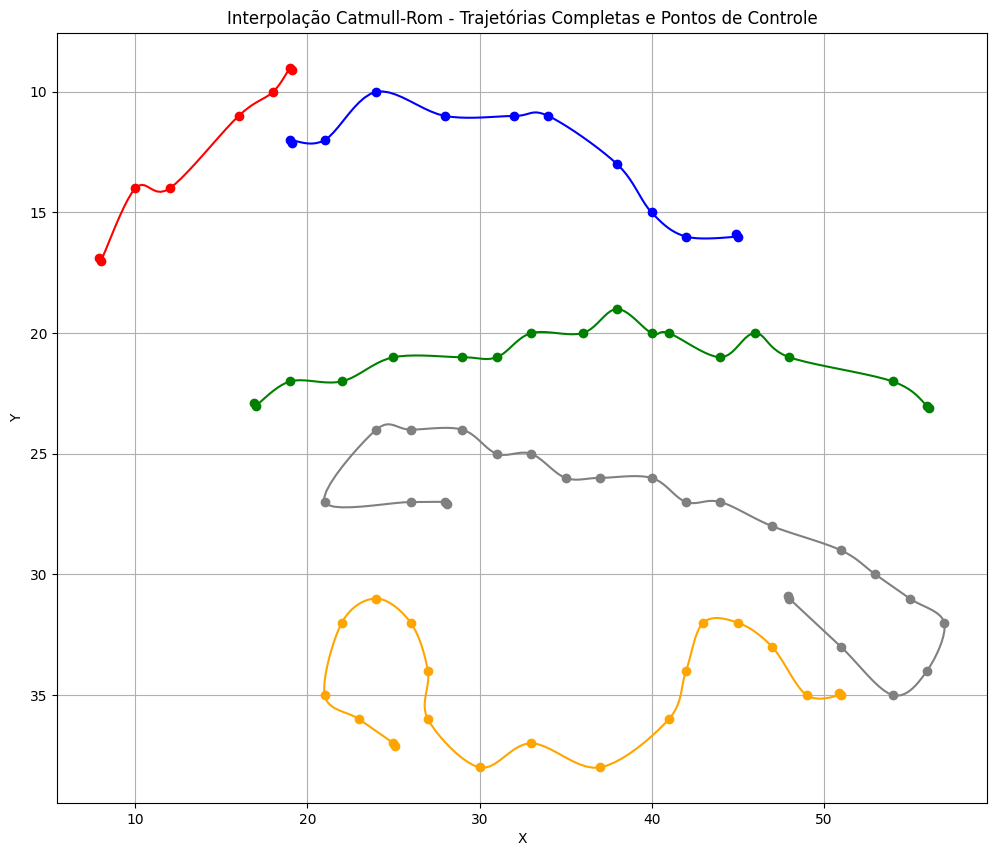

In [4]:
highlight_components(results[0][2].right_eye_dict, results[0][4].dic_main_right_eye_cc)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].longest_path_right_eye, results[0][5].nodes_right_eye)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].new_longest_path_right_eye, results[0][5].nodes_right_eye)
plot_splines(results[0][7].all_X_right_eye, results[0][7].all_Y_right_eye, results[0][7].all_control_x_right_eye, results[0][7].all_control_y_right_eye)


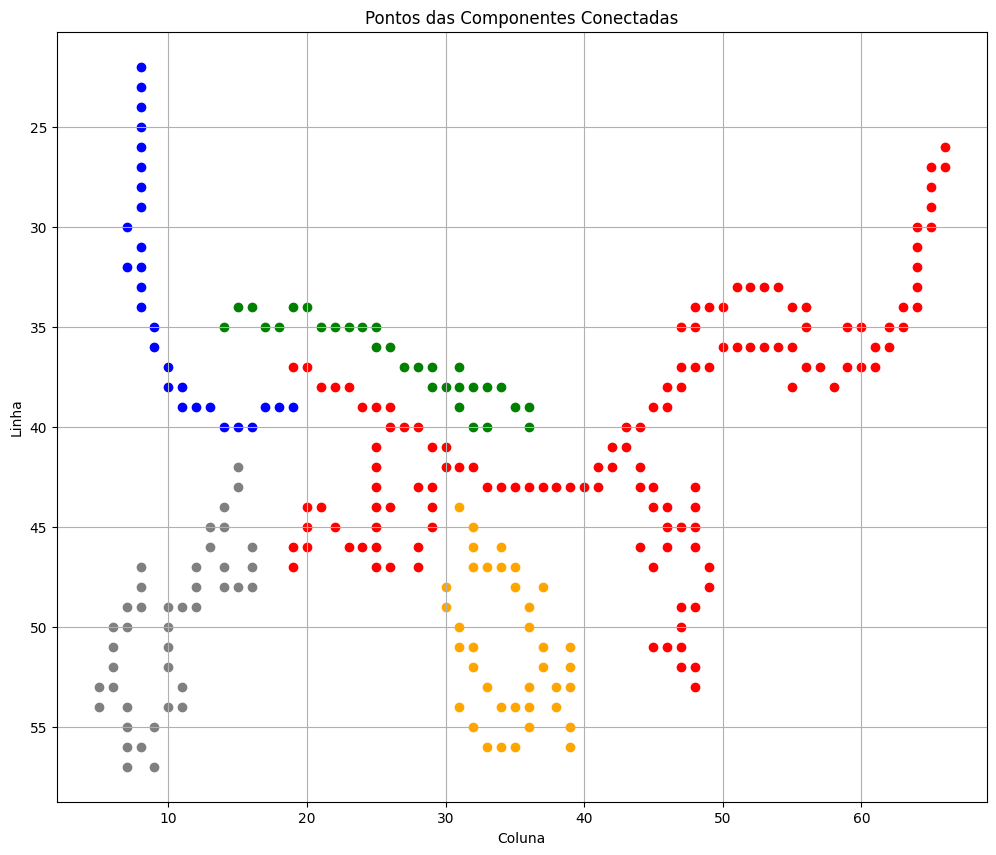

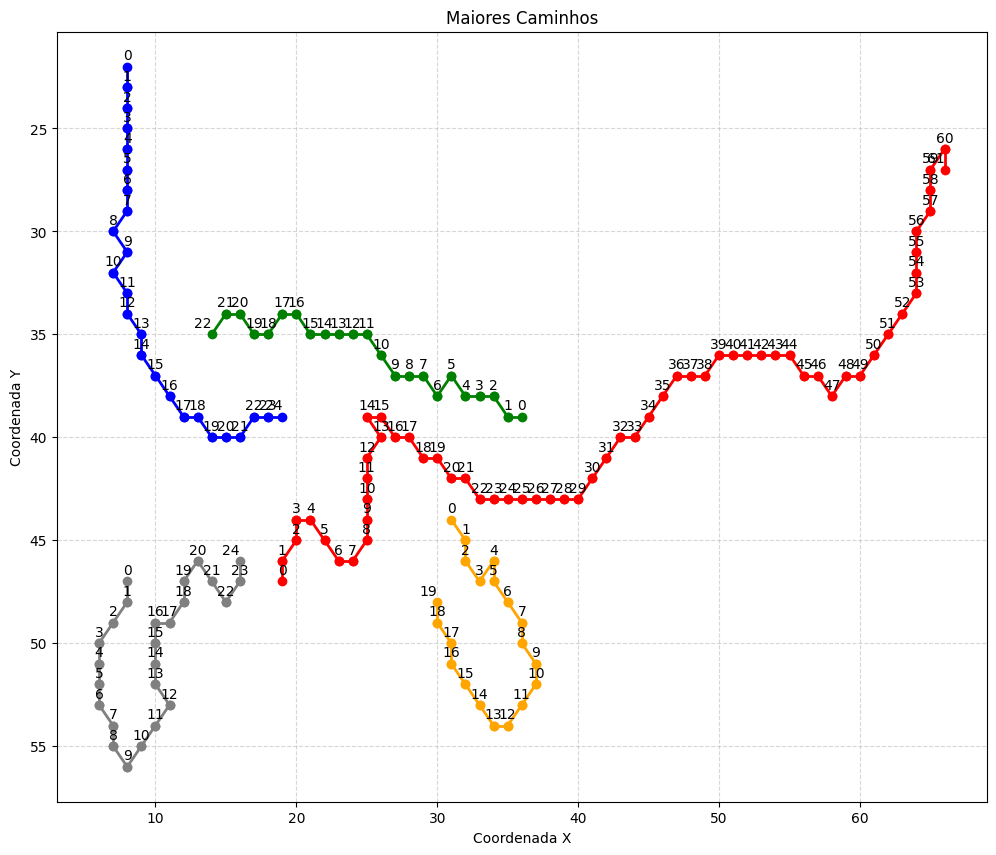

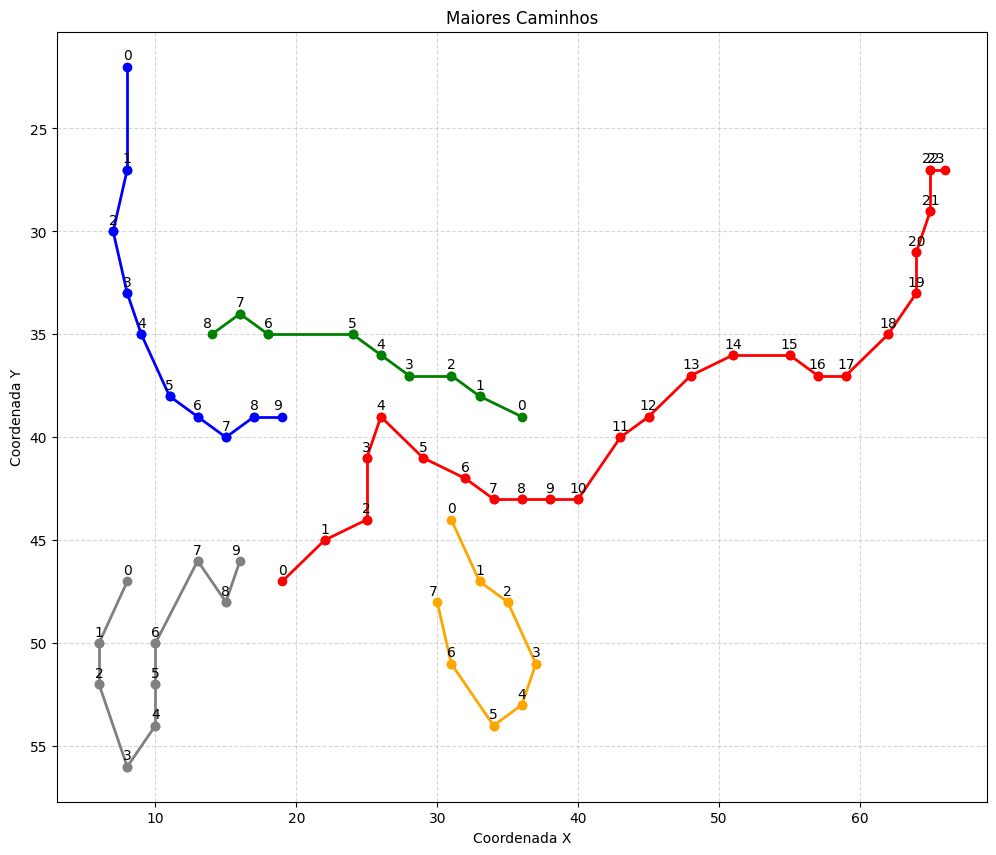

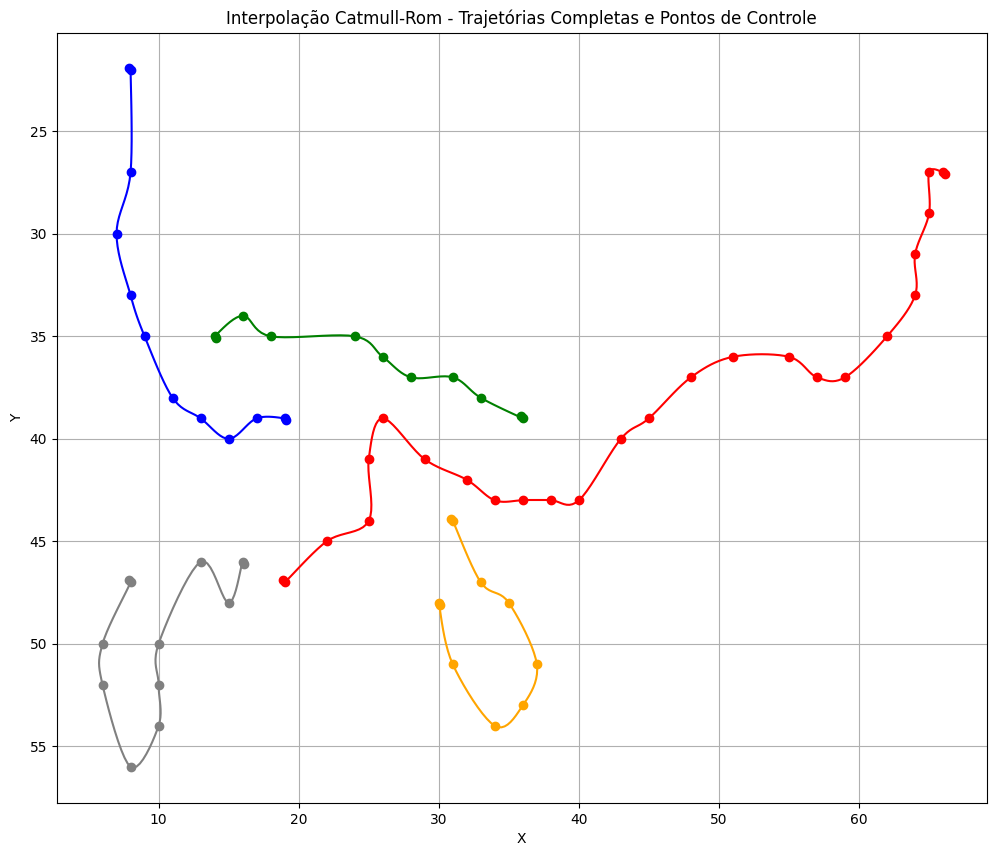

In [5]:
highlight_components(results[0][2].nose_dict, results[0][4].dic_main_nose_cc)
plot_logest_path(results[0][2].nose_dict, results[0][6].longest_path_nose, results[0][5].nodes_nose)
plot_logest_path(results[0][2].nose_dict, results[0][6].new_longest_path_nose, results[0][5].nodes_nose)
plot_splines(results[0][7].all_X_nose, results[0][7].all_Y_nose, results[0][7].all_control_x_nose, results[0][7].all_control_y_nose)


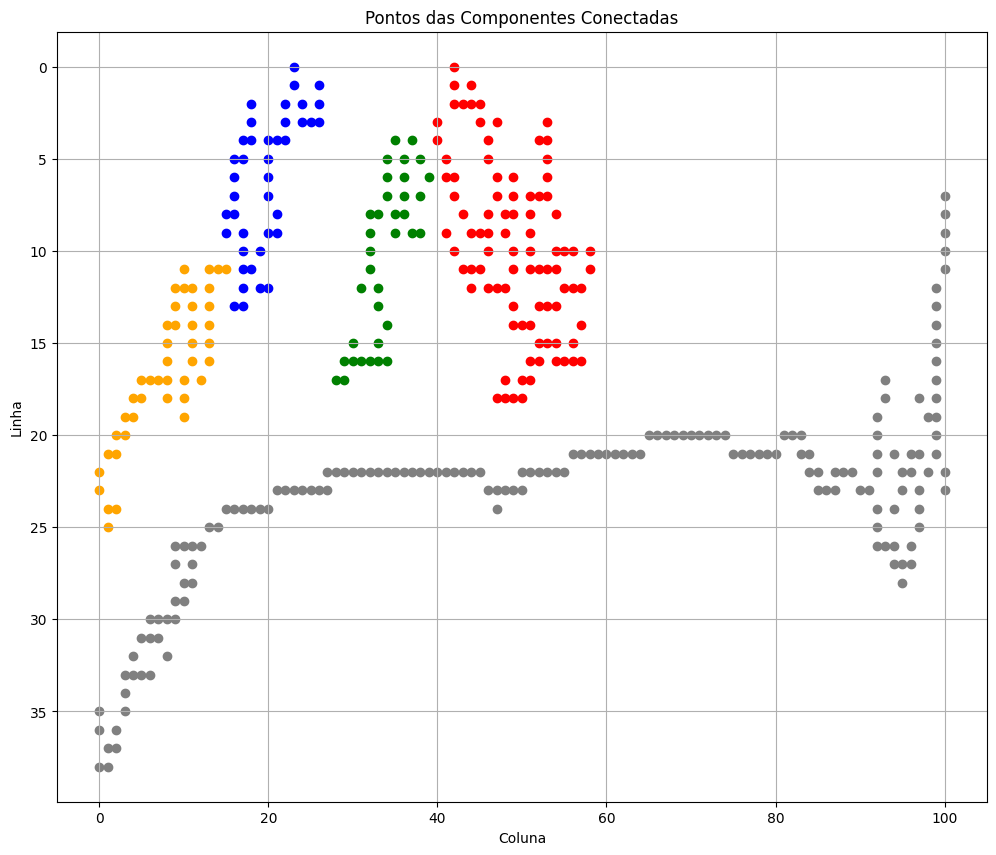

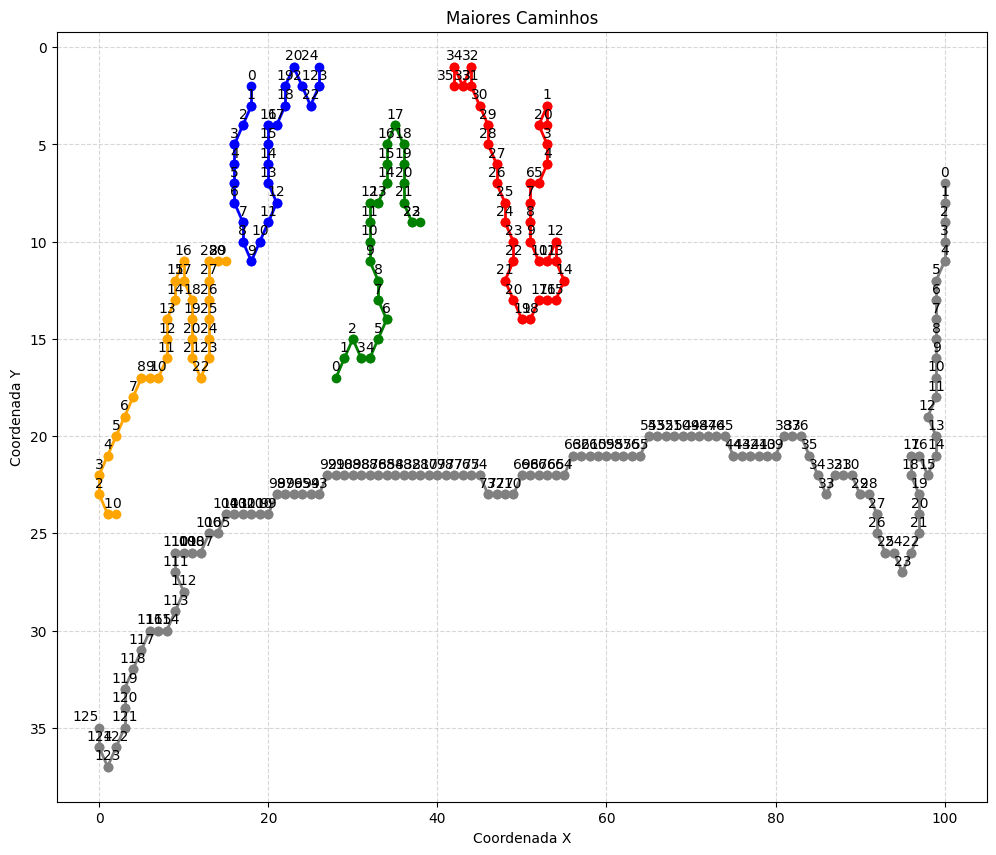

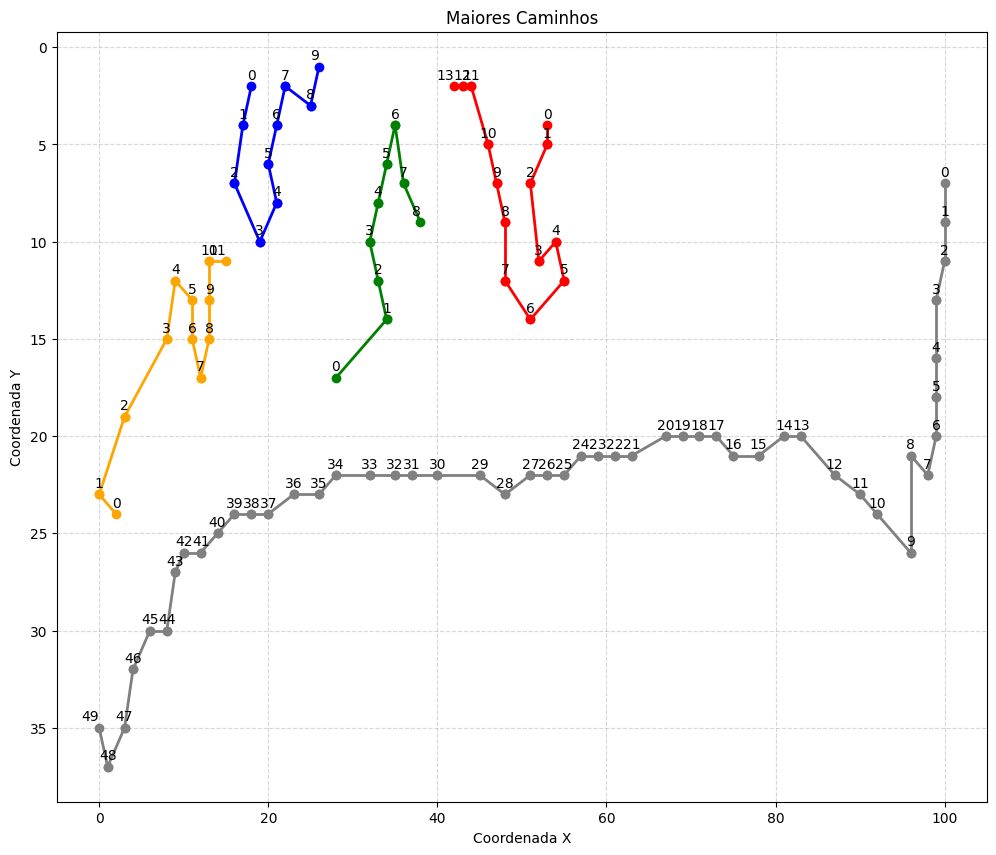

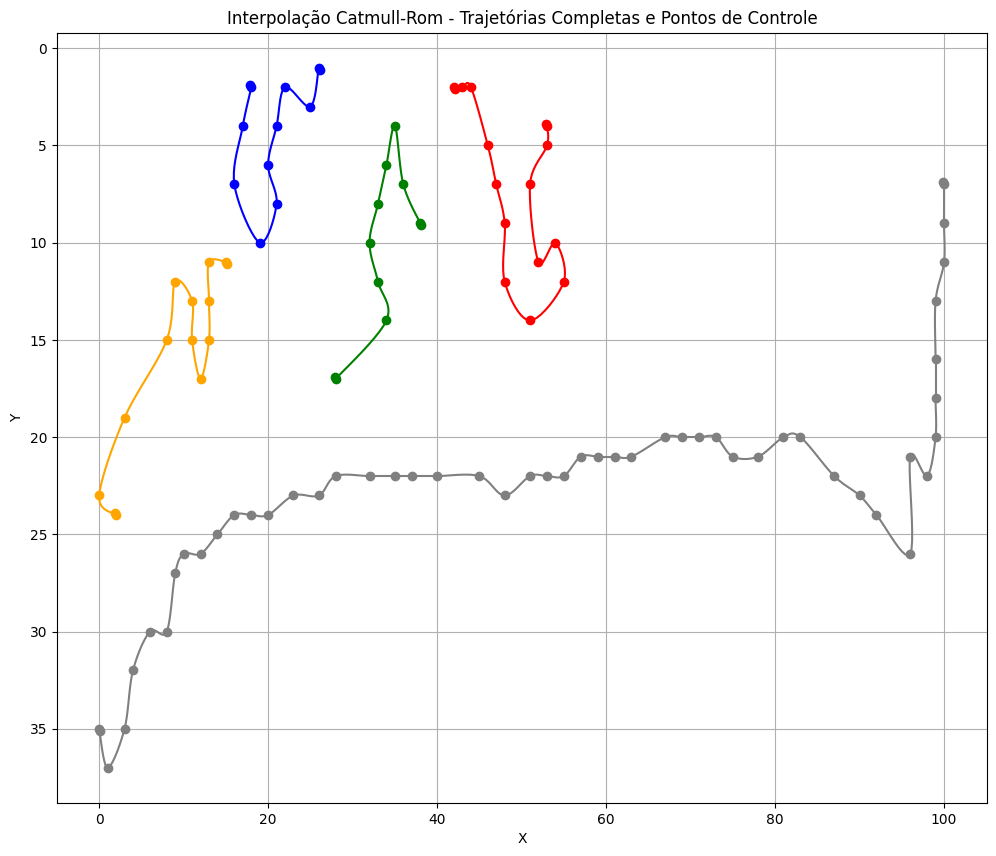

In [6]:

highlight_components(results[0][2].mouth_dict, results[0][4].dic_main_mouth_cc)
plot_logest_path(results[0][2].mouth_dict, results[0][6].longest_path_mouth, results[0][5].nodes_mouth)
plot_logest_path(results[0][2].mouth_dict, results[0][6].new_longest_path_mouth, results[0][5].nodes_mouth)
plot_splines(results[0][7].all_X_mouth, results[0][7].all_Y_mouth, results[0][7].all_control_x_mouth, results[0][7].all_control_y_mouth)